# Fine-tuning del modelo Donut preentrenado RVL-CDIP para clasificación de documentos

Este notebook incluye el entrenamiento, monitorización y evaluación del modelo Donut para la clasificación de documentos. Se aplica finetuning sobre el modelo Donut preentrenado en el dataset RVL-CDIP. Se extrae la precisión del modelo y el índice de confianza que determinará si un documento será procesado por el modelo o derivado al backoffice para su clasificación manual.

## Configuración del entorno

In [ ]:
import sys
print(sys.version)
!python --version  # checks version from command line

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Python 3.7.13


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets sentencepiece

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 120 kB 38.8 MB/s 
     |████████████████████████████████| 6.6 MB 52.4 MB/s 
     |████████████████████████████████| 365 kB 27.7 MB/s 
     |████████████████████████████████| 1.3 MB 70.9 MB/s 
     |████████████████████████████████| 115 kB 62.6 MB/s 
     |████████████████████████████████| 212 kB 58.8 MB/s 
     |████████████████████████████████| 127 kB 71.1 MB/s 


In [ ]:
!nvidia-smi

Thu Sep  8 16:53:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Cargar dataset


Utilizaremos el dataset [Mijavier/donut_custom_dataset](https://huggingface.co/datasets/Mijavier/10_classes_custom_dataset_donut), previamente creado en el notebook 1. Se conforma de 10 clases en total: 8 clases de Tobacco-3482 (ADVE, email, form, memo, news, note, report y resume), una clase de passport del conjunto de datos Pardo y una clase de receipt del dataset SROIE. Consistente en pares (imagen, texto). El texto es lo que el modelo debe aprender a generar dada la entrada visual.

Hay que crear una cadena llamada "ground_truth". Para la clasificación de imágenes de documentos, el `gt_parse` sigue el formato de `{"class" : {class_name}}`, por ejemplo, `{"class" : "scientific_report"}` o `{"class" : "presentation"}`.

Cargamos el conjunto de datos:

In [ ]:
from datasets import load_dataset
dataset = load_dataset("Mijavier/10_classes_custom_dataset_donut")

Downloading:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Mijavier___parquet/Mijavier--10_classes_custom_dataset_donut-8ec58e905c28691e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'ground_truth'],
        num_rows: 2800
    })
    test: Dataset({
        features: ['image', 'label', 'ground_truth'],
        num_rows: 700
    })
})

In [ ]:
id2label = {id: label for id, label in enumerate(dataset['train'].features['label'].names)}
print(id2label)

{0: 'ADVE', 1: 'email', 2: 'form', 3: 'memo', 4: 'news', 5: 'note', 6: 'passport', 7: 'receipt', 8: 'report', 9: 'resume'}


Veamos un ejemplo:

In [ ]:
example = dataset['train'][0]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=817x1089 at 0x7F4A9D0EDA10>,
 'label': 0,
 'ground_truth': '{"gt_parse": {"class" : "ADVE"}}'}

Como puede verse, se ha preparado la clave "ground_truth", que es un diccionario con formato de cadena que contiene una única clave "gt_parse".

In [ ]:
example = dataset["train"][0]
example["ground_truth"]

'{"gt_parse": {"class" : "ADVE"}}'

Se puede utilizar la función `ast.literal_eval` de Python para convertir la cadena en un diccionario de Python. Esto ayuda a verificar que hemos creado la cadena gt_parse de forma correcta:

In [ ]:
from ast import literal_eval
literal_eval(example["ground_truth"])['gt_parse']

{'class': 'ADVE'}

## Carga del model y processor

A continuación, se carga el modelo.

Se actualiza la longitud máxima de la secuencia del decodificador y el tamaño de las imágenes. Nota: Esto afecta a la cantidad de memoria utilizada cuando se aplica fine-tuning en el modelo.

Los hiperparámetros exactos se pueden encontrar aquí: https://github.com/clovaai/donut/blob/master/config/train_rvlcdip.yaml.

In [ ]:
from transformers import VisionEncoderDecoderConfig

max_length = 8
# image_size = [2560, 1920]
# let's use a smaller image size (height, width) because otherwise OOM
# the higher the resolution, the better the results will be
# so if you have a big GPU, feel free to increase
image_size = [1280, 960]

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base-finetuned-rvlcdip")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

Downloading:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

In [ ]:
from transformers import DonutProcessor, VisionEncoderDecoderModel, BartConfig

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-rvlcdip")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-rvlcdip", config=config)

Downloading:   0%|          | 0.00/803M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.feature_extractor.size = image_size[::-1] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

## Preparación del dataset

Se añaden los nombres de las clases como tokens añadidos al vocabulario del descodificador y al tokenizador correspondiente.

Esto supondrá un ligero aumento del rendimiento, ya que, de lo contrario, una clase podría dividirse en múltiples subpalabras (por ejemplo, la clase "advertisement" podría dividirse en "adv", "ertisement"). Resulta beneficioso dejar que el modelo aprenda un único vector de incrustación para el token "advertisement".

In [ ]:
len(processor.tokenizer)

57544

In [ ]:
from typing import List

def add_tokens(list_of_tokens: List[str]):
    """
    Add tokens to tokenizer and resize the token embeddings
    """
    newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
    if newly_added_num > 0:
        model.decoder.resize_token_embeddings(len(processor.tokenizer))

In [ ]:
additional_tokens = ["<ADVE/>", "<email/>", "<form/>", "<memo/>", "<news/>", "<note/>", "<passport/>", "<receipt/>", "<report/>", "<resume/>"]

add_tokens(additional_tokens)

In [ ]:
processor.tokenizer.convert_tokens_to_ids(["<file_folder/>"])

[57527]

In [ ]:
len(processor.tokenizer)

57550

A continuación, se crea un conjunto de datos PyTorch. La clase siguiente devuelve pares `(valores_píxel, labels)` para cada elemento del conjunto de datos.

Es todo lo que se necesita para entrenar el modelo.

In [ ]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

class DonutDataset(Dataset):
    """
    DonutDataset which is saved in huggingface datasets format. (see details in https://huggingface.co/docs/datasets)
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into input_tensor(vectorized image) and input_ids(tokenized string).
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in additional_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj

    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # pixel values (we remove the batch dimension)
        pixel_values = processor(sample["image"].convert("RGB"), random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # labels, which are the input ids of the target sequence
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)

        encoding = dict(pixel_values=pixel_values,
                        labels=labels)

        return encoding

Se crea el dataset:

In [ ]:
train_dataset = DonutDataset("Mijavier/10_classes_custom_dataset_donut", max_length=max_length,
                             split="train", task_start_token="<s_rvlcdip>", prompt_end_token="<s_rvlcdip>",
                             sort_json_key=False, # dataset is preprocessed, so no need for this
                             )

Se comprueba el primer elemento de este conjunto de datos:

In [ ]:
train_dataset[0]

{'pixel_values': tensor([[[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 'labels': tensor([57537, 57544, 57523,     2,  -100,  -100,  -100

## Monitorización

Se utiliza MLFow para monitorizar el modelo y Databricks como servidor.

In [ ]:
!pip install mlflow
!databricks configure --host https://community.cloud.databricks.com/
!python -m pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.0 MB 9.2 MB/s 
     |████████████████████████████████| 79 kB 10.0 MB/s 
     |████████████████████████████████| 146 kB 65.3 MB/s 
     |████████████████████████████████| 181 kB 53.2 MB/s 
     |████████████████████████████████| 209 kB 71.0 MB/s 
     |████████████████████████████████| 77 kB 8.0 MB/s 
     |████████████████████████████████| 78 kB 8.8 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 59 kB 7.6 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.17.3-py3-none-any.whl size=139102 sha256=838073cce0405a3947148fcc32ebfd3f1c2a3c58a726e5449f2ed7ab999721b4
  Stored in directory: /root/.cache/pip/wheels/3f/73/87/c1e4b2145eb6049bb6c9aaf7ea1e38302b77ca219b6fef5d5c
Successfully built databricks-cli
Username: mijavier77@gm

In [ ]:
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/mijavier77@gmail.com/Donut_01")

2022/09/08 16:57:38 INFO mlflow.tracking.fluent: Experiment with name '/Users/mijavier77@gmail.com/Donut_01' does not exist. Creating a new experiment.


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/3404404259936464', experiment_id='3404404259936464', lifecycle_stage='active', name='/Users/mijavier77@gmail.com/Donut_01', tags={'mlflow.experiment.sourceName': '/Users/mijavier77@gmail.com/Donut_01',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'mijavier77@gmail.com',
 'mlflow.ownerId': '3989251399721398'}>

Se inicaliza mlflow y se definen los parámetros de entrenamiento.

In [ ]:
# starting a new run ( a session ) within an experiment ( collection of runs )
current_run = mlflow.start_run()

# Setting parameters
batch_size = 1 # I'm using a small batch size to make sure it fits in the memory Colab provides
lr = 1e-5
num_epochs = 10

# logging the seed value to passed to the train_test_split function.
mlflow.log_param("batch_size", batch_size)
mlflow.log_param("lr", lr)
mlflow.log_param("epochs", num_epochs)
mlflow.pytorch.autolog()

## Creación PyTorch DataLoader

Ahora que se ha creado un conjunto de datos PyTorch, se puede crear el correspondiente DataLoader:



In [ ]:
from torch.utils.data import DataLoader

# I'm using a small batch size to make sure it fits in the memory Colab provides
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Se muestra el primer lote:

In [ ]:
batch = next(iter(train_dataloader))
print(batch.keys())

dict_keys(['pixel_values', 'labels'])


Se muestras las etiquetas:

In [ ]:
for id in batch['labels'][0].tolist():
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_class>
<receipt/>
</s_class>
</s>
-100
-100
-100
-100


Visualicemos los pixel values desnormalizando:

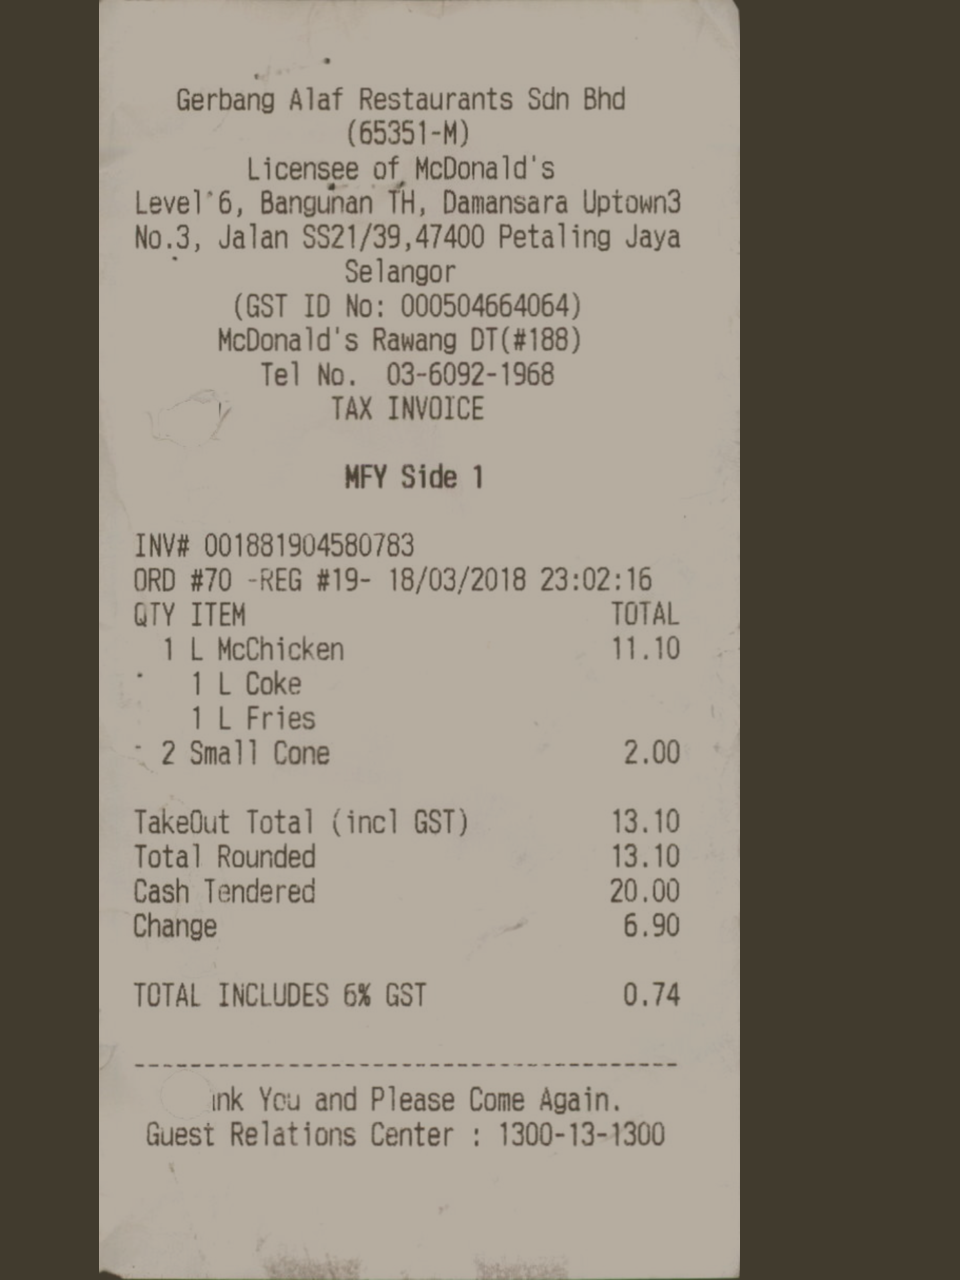

In [ ]:
from PIL import Image
import numpy as np

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# unnormalize
reconstructed_image = (batch['pixel_values'][0] * torch.tensor(std)[:, None, None]) + torch.tensor(mean)[:, None, None]
# unrescale
reconstructed_image = reconstructed_image * 255
# convert to numpy of shape HWC
reconstructed_image = torch.moveaxis(reconstructed_image, 0, -1)
image = Image.fromarray(reconstructed_image.numpy().astype(np.uint8))
image

En efecto, esto parece un recibo. Así que la preparación de los datos parece estar bien.

## Entrenamiento del modelo

Durante el entrenamiento, el modelo puede crear los `decoder_input_ids` (las entradas del decodificador) automáticamente basándose en las `labels` (simplemente desplazándolas una posición a la derecha, anteponiendo el `decoder_start_token_id` y reemplazando las etiquetas que son -100 por el `pad_token_id`). Por lo tanto, necesitamos establecer esas variables, para asegurarnos de que los `decoder_input_ids` se crean automáticamente.

Esto asegura que sólo se tienen que preparar las etiquetas para el modelo. Teóricamente también podemos crear los `decoder_input_ids` y no establecer las 2 variables de abajo. Esto es lo que hicieron los autores originales de Donut.

In [ ]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_rvlcdip>'])[0]

In [ ]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_rvlcdip>


¡Se entrena!

In [ ]:
def Average(lst):
    return sum(lst) / len(lst)

In [ ]:
import torch
from tqdm.auto import tqdm
import mlflow.pytorch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)

loss_list = []
steps_per_epoch = len(train_dataloader)

for epoch in range(num_epochs):
    print("Epoch:", epoch+1)
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]

        outputs = model(pixel_values=pixel_values,
                        labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_list.append(loss.item())

        mlflow.log_metric("loss", loss.item(), i+epoch*steps_per_epoch)

        if i % 100 == 0 and i !=0:
          loss_100_ma = Average(loss_list)
          mlflow.log_metric("loss_100_ma", loss_100_ma, i+epoch*steps_per_epoch)
          loss_list = []
          print("Loss:", loss_100_ma)

mlflow.pytorch.log_model(model, "models")
mlflow.end_run()

Epoch: 1


  0%|          | 0/2800 [00:00<?, ?it/s]

Loss: 0.026719693414901973
Loss: 0.02937910502733331
Loss: 0.034035508098104274
Loss: 0.053519032818301115
Loss: 0.00289983628724487
Loss: 0.015285094601972986
Loss: 0.05223184340891814
Loss: 0.044411899251596075
Loss: 0.04392662087571853
Loss: 0.03342217195158437
Loss: 0.026080163328686918
Loss: 0.027738228621720838
Loss: 0.083060630479795
Loss: 0.049204572200618364
Loss: 0.02370956461110957
Loss: 0.02046081092472594
Loss: 0.025028013557901404
Loss: 0.0074223983297265405
Loss: 0.0234138880052827
Loss: 0.07045293869967047
Loss: 0.02184363389382959
Loss: 0.01627790068829821
Loss: 0.012268585961662203
Loss: 0.00696397579554036
Loss: 0.040264037200094
Loss: 0.01983738182932333
Loss: 0.018709766017371763
Epoch: 2


  0%|          | 0/2800 [00:00<?, ?it/s]

Loss: 0.006637889021277674
Loss: 0.0013162423563492353
Loss: 0.014702567865097932
Loss: 0.036369412863545225
Loss: 0.0017688034597393098
Loss: 0.013625844340204871
Loss: 0.0024173667121875474
Loss: 0.0010795551872367427
Loss: 0.018935676759391527
Loss: 0.00593860679879521
Loss: 0.0023577469606012613
Loss: 0.00938158136965061
Loss: 0.00032993743288464825
Loss: 0.0009160094663357832
Loss: 0.008917093460391143
Loss: 0.005914522798062496
Loss: 0.0030317367188174415
Loss: 0.008695407406114963
Loss: 0.008079714749256901
Loss: 0.0008773016031981485
Loss: 0.006662807659759445
Loss: 0.0054207703798309125
Loss: 0.0006632004266539582
Loss: 0.05917295692034228
Loss: 0.00348358433999822
Loss: 0.006609079773380291
Loss: 0.003053740334737629
Epoch: 3


  0%|          | 0/2800 [00:00<?, ?it/s]

Loss: 0.017810739759118698
Loss: 0.004953092128732201
Loss: 0.002161920613633317
Loss: 0.002662234849561731
Loss: 9.35784359666414e-05
Loss: 0.0014573813135014824
Loss: 0.0004789363158186255
Loss: 0.0013890060950317107
Loss: 0.00040731627533064697
Loss: 0.0005310817069828389
Loss: 0.001470823018251668
Loss: 0.0010763079393308317
Loss: 0.008224741614976737
Loss: 0.014604926870898805
Loss: 0.002454136373492766
Loss: 0.00035517958840442177
Loss: 0.0004341940778768105
Loss: 0.0005411126607141092
Loss: 0.00019519548170988444
Loss: 0.00020709298920502662
Loss: 0.0010704662455314918
Loss: 0.0006289497084295092
Loss: 0.011234949554292122
Loss: 0.005484670683275663
Loss: 0.004504769293598372
Loss: 0.0011159301703097667
Loss: 0.003418238005999239
Epoch: 4


  0%|          | 0/2800 [00:00<?, ?it/s]

Loss: 0.010918084999180157
Loss: 0.00943364398267576
Loss: 0.03875759615772766
Loss: 0.0057642477662188975
Loss: 0.0009787999630619737
Loss: 0.001172887951803201
Loss: 0.0019749953026207655
Loss: 0.0007828682934919762
Loss: 0.0013075338856079277
Loss: 6.890737452684092e-05
Loss: 0.0005506372354792787
Loss: 9.359489842458046e-05
Loss: 8.932534154707738e-05
Loss: 0.00014972381843687544
Loss: 0.0026403638550362807
Loss: 0.007338519520526603
Loss: 0.0012173948118515908
Loss: 0.0031831250676186505
Loss: 0.00029941144937122743
Loss: 0.0009729690598845231
Loss: 0.0004129977958443476
Loss: 1.633054769420994e-05
Loss: 0.0008104320722729597
Loss: 0.00010516674840033602
Loss: 0.0010871560182236627
Loss: 0.00012513480498661523
Loss: 0.0014357012695277581
Epoch: 5


  0%|          | 0/2800 [00:00<?, ?it/s]

Loss: 0.009634894560294666
Loss: 0.019519690045682533
Loss: 0.009616461223948498
Loss: 0.010428139168075319
Loss: 8.532451596714452e-05
Loss: 0.00082014110505094
Loss: 0.0003964248421984706
Loss: 0.0036768727508614063
Loss: 0.004172258200940657
Loss: 0.013548359687649452
Loss: 0.002183768274673099
Loss: 0.010273458703735442
Loss: 0.0005138767649424381
Loss: 0.001470185359816565
Loss: 0.000593357753699788
Loss: 0.0007149519880470656
Loss: 0.0005347625427480019
Loss: 0.00012437700798450634
Loss: 1.8271295919181085e-05
Loss: 0.0017533889012365832
Loss: 0.0001426082163709097
Loss: 3.9376624525040424e-05
Loss: 9.603977075293812e-05
Loss: 1.6734514274272526e-05
Loss: 3.898717843753729e-05
Loss: 0.01747199131902015
Loss: 0.0001464425433551675
Epoch: 6


  0%|          | 0/2800 [00:00<?, ?it/s]

Loss: 0.000635644449951247
Loss: 4.333997721825966e-05
Loss: 0.00012914974620075625
Loss: 0.01847612256689887
Loss: 0.00046077548896338526
Loss: 0.010415578160049819
Loss: 0.00038182924518705976
Loss: 0.005261482017788115
Loss: 0.003918795572640885
Loss: 6.0968754885841746e-05
Loss: 0.0004919697540733558
Loss: 4.995843383822418e-05
Loss: 0.00023355320383837254
Loss: 0.00036822997340031806
Loss: 5.138752538863756e-05
Loss: 0.0020221863383655327
Loss: 0.014851150146440499
Loss: 0.001453082747855934
Loss: 0.0012963113303056416
Loss: 0.00011432977931841393
Loss: 0.0003531442321390443
Loss: 0.001451608783108771
Loss: 0.0017023097532867836
Loss: 0.012855195670315265
Loss: 0.0010762679243446272
Loss: 0.00011911399883109297
Loss: 0.001296242681362063
Epoch: 7


  0%|          | 0/2800 [00:00<?, ?it/s]

Loss: 0.0072144663927581655
Loss: 0.00016084932861419433
Loss: 9.61709693335422e-05
Loss: 0.0004054893074747845
Loss: 6.184720509239128e-06
Loss: 0.0017924433719241329
Loss: 0.0005674614347193873
Loss: 0.00010509825771421787
Loss: 7.153471473527518e-05
Loss: 5.2254171960264275e-06
Loss: 6.616984773552659e-05
Loss: 0.0003298781564655329
Loss: 0.010146156804363092
Loss: 0.013519881824502313
Loss: 0.018721877992169594
Loss: 0.008817261183815841
Loss: 0.026888845173827107
Loss: 0.0018115013319227912
Loss: 0.014528033017421862
Loss: 0.027235479327788623
Loss: 0.0010380341718283148
Loss: 0.005026794818443392
Loss: 0.003504253482444124
Loss: 7.850766036911594e-05
Loss: 0.0027075593421154133
Loss: 0.0025354228382840206
Loss: 0.008165133649859567
Epoch: 8


  0%|          | 0/2800 [00:00<?, ?it/s]

Loss: 0.00018393379609848992
Loss: 0.002201298941155194
Loss: 0.001891913738289972
Loss: 0.00014268178832136158
Loss: 4.73200140015706e-05
Loss: 0.00033562536162602187
Loss: 0.0001002272572926266
Loss: 0.0015634682681725388
Loss: 0.011239754298221242
Loss: 0.00047497066947634894
Loss: 0.0015773758525191185
Loss: 0.0012121009386000558
Loss: 0.004179402275565814
Loss: 9.629606438691595e-05
Loss: 2.7348635780288787e-05
Loss: 0.0008969138298306944
Loss: 0.009711561499976736
Loss: 4.8521764017852576e-05
Loss: 0.004117224708636691
Loss: 5.4120888366124834e-05
Loss: 0.0011285811056209205
Loss: 1.3255798242362005e-05
Loss: 2.4188593271432523e-05
Loss: 3.3407427376133114e-05
Loss: 3.7229150010116286e-05
Loss: 7.879551028313614e-06
Loss: 0.0003317388128892418
Epoch: 9


  0%|          | 0/2800 [00:00<?, ?it/s]

Loss: 0.0002013898405005765
Loss: 0.0020387160195503816
Loss: 0.007962083823522797
Loss: 0.001107980855407682
Loss: 8.667165713163173e-06
Loss: 0.006852030072563249
Loss: 0.010331719247827777
Loss: 0.02376718625603857
Loss: 8.627653436528604e-05
Loss: 1.683881985288238e-05
Loss: 0.0019424547223361088
Loss: 4.990204328739978e-05
Loss: 0.009292180929326488
Loss: 0.0003572184878744267
Loss: 0.00029822178140863185
Loss: 2.0611374401582338e-05
Loss: 0.009847907493786162
Loss: 0.002077065410311363
Loss: 0.0010229291811283047
Loss: 0.013447228850793937
Loss: 0.0003996045546312743
Loss: 0.018649856935202463
Loss: 0.0001388232218890728
Loss: 0.00953401861570299
Loss: 0.0005990631584741557
Loss: 0.0003107319773423356
Loss: 0.004878031126236308
Epoch: 10


  0%|          | 0/2800 [00:00<?, ?it/s]

Loss: 0.0005540541089614859
Loss: 0.03728926500430086
Loss: 0.02861482669130279
Loss: 0.0011898815629347403
Loss: 0.0007081860838753862
Loss: 0.010854246487973037
Loss: 8.181459844864847e-05
Loss: 0.005089388545171225
Loss: 0.0009406444828550952
Loss: 0.007577502172611563
Loss: 0.00019436364876648682
Loss: 0.0018401682339258408
Loss: 0.00015857409021089453
Loss: 0.00020847488307394358
Loss: 6.209969673040661e-05
Loss: 0.007422161623173658
Loss: 0.009060401277003204
Loss: 0.00945238356046417
Loss: 0.0005825105336026227
Loss: 0.0008102745576131199
Loss: 8.768917826323274e-05
Loss: 7.799822302485993e-05
Loss: 0.0006101540746486655
Loss: 1.4166319209749644e-05
Loss: 3.64654167145595e-05
Loss: 0.0024218269114395594
Loss: 0.0008926791278389423


2022/09/08 23:15:09 WARNING mlflow.utils.requirements_utils: Found torch version (1.12.1+cu113) contains a local version label (+cu113). MLflow logged a pip requirement for this package as 'torch==1.12.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/09/08 23:15:16 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpn76v304b/model/data, flavor: pytorch), fall back to return ['torch==1.12.1', 'cloudpickle==1.5.0']. Set logging level to DEBUG to see the full traceback.


Nota: Las métricas obtenidas por MLFlow se incluyen en la memoria.

## Evaluación del modelo

Por último, se calcula la precisión en el conjunto de pruebas y el nivel de confianza de cada muestra de test.

Utilizaremos el método token2json del procesador para convertir las secuencias generadas en JSON.

In [ ]:
def calculate_confidence(outputs, decoder_input_ids):
  gen_sequences = outputs.sequences[:, decoder_input_ids.to(device).shape[-1]:-1]
  probs = torch.stack(outputs.scores, dim=1).softmax(-1)
  gen_probs = torch.gather(probs, 2, gen_sequences[:, :, None]).squeeze(-1)
  unique_prob_per_sequence = gen_probs.prod(-1)

  return unique_prob_per_sequence.item()

In [ ]:
def classification(outputs):
  seq = processor.batch_decode(outputs.sequences)[0]
  seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
  seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
  output = processor.token2json(seq)["class"] # convert to json and extract class

  return output

In [ ]:
def inference(pixel_values, decoder_input_ids):
  # autoregressively generate sequence
  outputs = model.generate(
              pixel_values,
              decoder_input_ids=decoder_input_ids.to(device),
              max_length=model.decoder.config.max_position_embeddings,
              early_stopping=True,
              pad_token_id=processor.tokenizer.pad_token_id,
              eos_token_id=processor.tokenizer.eos_token_id,
              use_cache=True,
              num_beams=1,
              bad_words_ids=[[processor.tokenizer.unk_token_id]],
              return_dict_in_generate=True,
              output_scores=True,)

  return outputs

In [ ]:
import re
import torch
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

# create a dataframe for the evaluation info
df = pd.DataFrame(columns=['idx', 'confidence', 'accuracy', 'y_real', 'y_pred'])

model.eval()
dataset = load_dataset("Mijavier/10_classes_custom_dataset_donut", split="test")

for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_rvlcdip>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # calculate inference outputs
    outputs = inference(pixel_values, decoder_input_ids)

    # confidance calculation
    confidence = calculate_confidence(outputs, decoder_input_ids)

    # class prediction
    class_pred = classification(outputs)

    # accuracy calculation
    ground_truth = json.loads(sample["ground_truth"])
    gt = ground_truth["gt_parse"]
    score = float(class_pred == gt["class"])

    df.loc[len(df.index)] = [idx, confidence, score, gt["class"], class_pred]

  0%|          | 0/700 [00:00<?, ?it/s]

In [ ]:
display(df)

# mean accuracy
mean_acc = round(df["accuracy"].mean()*100, 2)
print("Accuracy: " + str(mean_acc) + "%")

,idx,confidence,accuracy,y_real,y_pred
0,0,0.999896,1.0,ADVE,ADVE
1,1,0.999995,1.0,ADVE,ADVE
2,2,0.999988,1.0,ADVE,ADVE
3,3,1.000000,1.0,ADVE,ADVE
4,4,1.000000,1.0,ADVE,ADVE
...,...,...,...,...,...
695,695,1.000000,1.0,resume,resume
696,696,0.999999,1.0,resume,resume
697,697,1.000000,1.0,resume,resume
698,698,1.000000,1.0,resume,resume


Accuracy: 84.43%


Se calculan las métricas precision, recall, F1 claculation y support.

In [ ]:
# precision, recall, F1 claculation and support
def division(n, d):
    return n / d if d !=0 else 0

def metrics(df, class_name):
  df_total_pos = df[df['y_real'] == class_name]
  df_total_neg = df[df['y_real'] != class_name]

  TP = df_total_pos[df_total_pos['y_pred'] == class_name].shape[0]
  FN = df_total_pos[df_total_pos['y_pred'] != class_name].shape[0]
  TN = df_total_neg[df_total_neg['y_pred'] != class_name].shape[0]
  FP = df_total_neg[df_total_neg['y_pred'] == class_name].shape[0]

  precision = division(TP, TP+FP)
  recall = division(TP, TP+FN)
  F1 = 2 * division(precision*recall, precision+recall)
  support = df_total_pos.shape[0]

  return precision, recall, F1, support

In [ ]:
# create a dataframe for the evaluation info
df_metrics = pd.DataFrame(columns=['class_name', 'precision', 'recall', 'F1', 'support'])

classes=["passport", "ADVE", "email", "form", "memo", "news", "note", "receipt", "report", "resume"]

for cl in classes:
  results = metrics(df, cl)
  results = (cl,) + results
  df_metrics.loc[len(df_metrics)] = results

display(df_metrics)

,class_name,precision,recall,F1,support
0,passport,1.000000,1.000000,1.000000,64
1,ADVE,0.569620,1.000000,0.725806,45
2,email,1.000000,0.423729,0.595238,118
3,form,0.890411,0.764706,0.822785,85
4,memo,0.947368,0.955752,0.951542,113
5,news,1.000000,0.974359,0.987013,39
6,note,0.967742,0.731707,0.833333,41
7,receipt,0.982906,1.000000,0.991379,115
8,report,0.476190,0.925926,0.628931,54
9,resume,0.896552,1.000000,0.945455,26


Se observa que las clases que peor rendimiento tienen en el modelo son email y report.

Con un 84.43% de accuracy no cumplimos con el requisito del enunciado, establecido en un 98%.
Hay que tener en cuenta de que:
 * Se ha utilizado una media de sólo 300 muestras por cada clase. La clase que menos tiene es resume con 112 muestras.  
 * Se ha entrenado sólo durante 10 épocas

Con mayor tiempo para el desarrollo y/o mayor capacidad computacional, se podrían aumentar las muestras de entrenamiento y el número de épocas.

En este caso, ya que como uno de los KPIs del enunciado es que se permite una automatización >= 60%, voy a descartar de la validación del modelo aquellas muestras que tengan una confianza inferior a un cierto índice.

In [ ]:
# Define a confidence index to balance between % of filtered data and accuracy
confidence_index = .9998

# Filter data
df_filter = df[df['confidence'] > confidence_index]
display(df_filter)

# mean accuracy of filtered data
mean_fil_acc = round(df_filter["accuracy"].mean()*100, 2)

# % of filtered data
num_df = df.shape[0]
num_df_filter = df_filter.shape[0]
per_filtered = round(num_df_filter/num_df*100, 2)

print("Accuracy of filtered data: " + str(mean_fil_acc) + "%")
print("% of filtered data: " + str(per_filtered) + "%")

,idx,confidence,accuracy,y_real,y_pred
0,0,0.999896,1.0,ADVE,ADVE
1,1,0.999995,1.0,ADVE,ADVE
2,2,0.999988,1.0,ADVE,ADVE
3,3,1.000000,1.0,ADVE,ADVE
4,4,1.000000,1.0,ADVE,ADVE
...,...,...,...,...,...
695,695,1.000000,1.0,resume,resume
696,696,0.999999,1.0,resume,resume
697,697,1.000000,1.0,resume,resume
698,698,1.000000,1.0,resume,resume


Accuracy of filtered data: 98.63%
% of filtered data: 62.43%


Se calculan las métricas precision, recall, F1 claculation y support.

In [ ]:
# create a dataframe for the evaluation info
df_metrics_filter = pd.DataFrame(columns=['class_name', 'precision', 'recall', 'F1', 'support'])

for cl in classes:
  results = metrics(df_filter, cl)
  results = (cl,) + results
  df_metrics_filter.loc[len(df_metrics_filter)] = results

display(df_metrics_filter)

,class_name,precision,recall,F1,support
0,passport,1.000000,1.000000,1.000000,53
1,ADVE,0.976744,1.000000,0.988235,42
2,email,1.000000,1.000000,1.000000,16
3,form,1.000000,0.933333,0.965517,30
4,memo,0.978723,0.989247,0.983957,93
5,news,1.000000,1.000000,1.000000,20
6,note,1.000000,0.818182,0.900000,11
7,receipt,1.000000,1.000000,1.000000,115
8,report,0.937500,0.967742,0.952381,31
9,resume,0.962963,1.000000,0.981132,26


Con un índice de confianza de 0.9998 cumplimos con los KPIs del enunciado:

*   Precisión alcanzada: 98.63% (objetivo>=98%)
*   Automatización: 62.43% (objetivo>=60%)

Compruebo, por curiosidad, el accuracy de los datos con peores confianzas:

In [ ]:
# Filter data
df_filter_worst = df[df['confidence'] <= confidence_index]
display(df_filter_worst)

# % of filtered data
num_df = df.shape[0]
num_df_filter = df_filter_worst.shape[0]
per_filtered = round(num_df_filter/num_df*100, 2)

# mean accuracy of filtered data
mean_fil_acc = round(df_filter_worst["accuracy"].mean()*100, 2)

print("% of filtered data: " + str(per_filtered) + "%")
print("Accuracy of filtered data: " + str(mean_fil_acc) + "%")

,idx,confidence,accuracy,y_real,y_pred
8,8,0.986499,1.0,ADVE,ADVE
11,11,0.998102,1.0,ADVE,ADVE
18,18,0.993532,1.0,ADVE,ADVE
47,47,0.999675,1.0,email,email
61,61,0.609268,0.0,email,report
...,...,...,...,...,...
664,664,0.999410,1.0,report,report
669,669,0.613605,1.0,report,report
670,670,0.650411,1.0,report,report
671,671,0.957685,1.0,report,report


% of filtered data: 37.57%
Accuracy of filtered data: 60.84%


El accuracy de las muestras con peores confianzas cae al 61%.

Se calculan las métricas precision, recall, F1 claculation y support de estas muestras.

In [ ]:
# create a dataframe for the evaluation info
df_metrics_filter_worst = pd.DataFrame(columns=['class_name', 'precision', 'recall', 'F1', 'support'])

for cl in classes:
  results = metrics(df_filter_worst, cl)
  results = (cl,) + results
  df_metrics_filter_worst.loc[len(df_metrics_filter_worst)] = results

display(df_metrics_filter_worst)

,class_name,precision,recall,F1,support
0,passport,1.000000,1.000000,1.000000,11
1,ADVE,0.083333,1.000000,0.153846,3
2,email,1.000000,0.333333,0.500000,102
3,form,0.822222,0.672727,0.740000,55
4,memo,0.800000,0.800000,0.800000,20
5,news,1.000000,0.947368,0.972973,19
6,note,0.954545,0.700000,0.807692,30
7,receipt,0.000000,0.000000,0.000000,0
8,report,0.273973,0.869565,0.416667,23
9,resume,0.000000,0.000000,0.000000,0


En la puesta en producción del modelo, los documentos que no tengan un índice de confiaza mayor al 0.9998, no se clasificarán automáticamente y se derivarán a un back-office para que se procesen manualmente.

## Push del modelo Donut

Por último, subimos este modelo a Hugging Face para poder reutilizarlo fácilmente, compartirlo, etc.

In [ ]:
!pip install git-lfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
# you can simply add `private=True` in case you're using the private hub
model.push_to_hub("Mijavier/finetuned_donut_10_classes_mlflow")
processor.push_to_hub("Mijavier/finetuned_donut_10_classes_mlflow")